In [ ]:
!pip install keras_metrics owlready2 fasttext

from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks')


     |████████████████████████████████| 20.8MB 1.5MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
  Created wheel for owlready2: filename=Owlready2-0.24-cp36-cp36m-linux_x86_64.whl size=20262992 sha256=04ea47383edb93e92543235a2ddb2b27f562f42c88d40062b9c606db1ed780d4
  Stored in directory: /root/.cache/pip/wheels/66/87/0b/7a97bd19c9dc817b279aadb5dd920ce3a77050e2ab5a413f43
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3015348 sha256=89551abd836eb753bd309cebf274cb2166adae72d568959a4b0d9fa6ea52c226
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built owlready2 fasttext
Mounted at /content/drive


# Création fichier paires négatives


In [ ]:
def nettoyer_unicode(c):
    liste_codes =  {
        'Ã\xa0': 'à',
        'Ã€': 'À',
        'Ã¢': 'â',
        'ã': 'â',
        'Ã‚': 'Â',
        'Ã©': 'é',
        'Ã©': 'é',
        'ã‰': 'é',
        'ãƒâ©': 'é',
        'Ã\x89': 'É',
        'Ã\xa8': 'è',
        'Ã\xaa': 'ê',
        'Ã\x8a': 'Ê', 
        'Ã¨': 'ê',       
        'Ã«': 'ë',
        'Ã®':'î',
        'Ã\x8e':'Î',        
        'Ã¯': 'ï', 
        'Ã´': 'ô',
        'Ã\x94': 'Ô',
        'Ã¹': 'ù', 
        'Ã»': 'û',
        'Å\x93': 'œ', 
        'Â«': '«',
        'Â»': '»',
        'Ã§': 'ç',
        'Ã\x87': 'Ç',
        'Âº': 'º',
        'â€™': '’',
        'â\x80\x99': '’',
        'â\x80\xa6' : '…',
    }
    
    for code in liste_codes:
        c = c.replace(code,liste_codes[code])
    return c

In [ ]:
import numpy as np
from sklearn.utils import shuffle

#Paires positives
paires_pos = np.load("/content/drive/My Drive/Colab Notebooks/paires_pos.npy", allow_pickle = True)
# paires_pos = np.load("Desktop/paires_pos.npy", allow_pickle = True)

#Paires negatives
paires_neg = np.load("/content/drive/My Drive/Colab Notebooks/paires_neg.npy", allow_pickle = True)
# paires_neg = np.load("Desktop/paires_neg.npy", allow_pickle = True)

print(len(paires_pos), "paires positives")
print(len(paires_neg), "paires negatives")

#training
rand_pos_indices = np.random.choice(paires_pos.shape[0], 8250, replace=False)
training_data_pos = paires_pos[rand_pos_indices]
rand_neg_indices = np.random.choice(paires_neg.shape[0], 8250, replace=False)
training_data_neg = paires_neg[rand_neg_indices]

#training data
# formatter en X et Y pour CNN
id = []
titre1 = []
titre2 = []
for pair in training_data_neg:
  id.append(0)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
for pair in training_data_pos:
  id.append(1)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
train_data = shuffle(titre1, titre2, id)

#test
#get remaining pairs
remaining_pos_indices = np.array([x for x in np.arange(paires_pos.shape[0]) if not np.isin(x, rand_pos_indices)])
remaining_neg_indices = np.array([x for x in np.arange(paires_neg.shape[0]) if not np.isin(x, rand_neg_indices)])
remaining_pos = paires_pos[remaining_pos_indices]
remaining_neg = paires_neg[remaining_neg_indices]

#sélection aléatoire 500 paires positives et négatives
test_indices_pos = np.random.choice(remaining_pos.shape[0], 500, replace=False)
test_data_pos = remaining_pos[test_indices_pos]
test_indices_neg = np.random.choice(remaining_neg.shape[0], 500, replace=False)
test_data_neg = remaining_neg[test_indices_neg]

id = []
titre1 = []
titre2 = []
for pair in test_data_neg:
  id.append(0)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
for pair in test_data_pos:
  id.append(1)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
test_data = shuffle(titre1, titre2, id)


8950 paires positives
95882 paires negatives


Récupérer FastText

On réalise la tokenisation du texte

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

#generation du vocabulaire
tokenizer = Tokenizer(filters=',"!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', char_level=True )
tokenizer.fit_on_texts(train_data[0] + train_data[1])
# tokenizer.fit_on_sequence

len_seq = 150
len_dict = len(tokenizer.word_counts) + 1
print(tokenizer.word_index)

#training data transformation en vecteurs
train_data[0] = pad_sequences(tokenizer.texts_to_sequences(train_data[0]), maxlen=len_seq)
train_data[1] = pad_sequences(tokenizer.texts_to_sequences(train_data[1]), maxlen=len_seq)
print(train_data[0])
#concatenate word vectors
conc = []
for index, val in enumerate(train_data[0]):
  conc.append(np.concatenate([train_data[0][index], train_data[1][index]]))
train_data.append(conc)

#testing data
test_data[0] = pad_sequences(tokenizer.texts_to_sequences(test_data[0]), maxlen=len_seq)
test_data[1] = pad_sequences(tokenizer.texts_to_sequences(test_data[1]), maxlen=len_seq)

#concatenate word vectors
conc = []
for index, val in enumerate(test_data[0]):
  conc.append(np.concatenate([test_data[0][index], test_data[1][index]]))
test_data.append(conc)

{' ': 1, 'e': 2, 'l': 3, 's': 4, 'a': 5, 'r': 6, 'i': 7, 'o': 8, 'n': 9, 't': 10, 'u': 11, 'd': 12, 'm': 13, 'c': 14, 'p': 15, 'é': 16, 'g': 17, 'v': 18, 'h': 19, 'b': 20, 'f': 21, "'": 22, '-': 23, 'è': 24, 'q': 25, ',': 26, 'j': 27, 'y': 28, '1': 29, 'x': 30, '2': 31, 'k': 32, 'à': 33, 'ê': 34, '.': 35, '!': 36, '3': 37, '0': 38, 'z': 39, '(': 40, ')': 41, 'â': 42, '/': 43, '4': 44, 'º': 45, ':': 46, '9': 47, 'ô': 48, '5': 49, '°': 50, '6': 51, '7': 52, 'î': 53, 'w': 54, '8': 55, ';': 56, 'ë': 57, 'œ': 58, 'ï': 59, '?': 60, '[': 61, ']': 62, 'ç': 63, '’': 64, 'û': 65, '&': 66, '#': 67, 'ã': 68, '=': 69, 'ù': 70, '\xa0': 71, '\x80': 72, 'ü': 73, '"': 74, '–': 75, '…': 76, 'í': 77, '@': 78, '¼': 79, 'ö': 80, '\n': 81, 'á': 82, '+': 83, '_': 84, '«': 85, '»': 86, 'ä': 87, 'å': 88, '\x92': 89, '\x88': 90, 'ó': 91, '\xad': 92, '½': 93, '\x84': 94, '¶': 95, '*': 96, '%': 97, '\x99': 98, '²': 99, '̂': 100, '¿': 101, 'š': 102, '³': 103, 'ñ': 104, 'ø': 105, '¢': 106, '£': 107}
[[ 0  0  0 ... 


On va maintenant utiliser Fasttext pour définir les embeddings

In [ ]:
import io
import os
import numpy as np

# si il n'existe pas déjà une matrice de crée
# characters
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/weights_char_fast.npy'):
# if not os.path.exists('Desktop/weights.npy'):
  print('Computing character weights')
  embedding_vectors = {}
  fin = io.open('Desktop/cc.fr.300.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')
  for line in fin:
    line_split = line.strip().split(" ")
    vec = np.array(line_split[1:], dtype=float)
    word = line_split[0]
    for char in word:
      if ord(char) < 128:
        if char in embedding_vectors:
          embedding_vectors[char] = (embedding_vectors[char][0] + vec, embedding_vectors[char][1] + 1)
        else:
          embedding_vectors[char] = (vec, 1)

else:
  m_embedding = np.load('/content/drive/My Drive/Colab Notebooks/weights_char_fast.npy', allow_pickle=True)

Création du modèle

In [ ]:
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
from time import time
import tensorflow.keras as keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GaussianNoise, BatchNormalization, Bidirectional, TimeDistributed
from keras.layers import Conv2D, AveragePooling1D, MaxPooling2D, Conv1D, MaxPooling1D, Embedding, LSTM
from keras_metrics import precision, recall, f1_score, binary_precision, binary_f1_score, binary_recall
from keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from nltk.metrics import edit_distance
from keras.utils import plot_model
import matplotlib.pyplot as plt

def createLSTM():
  model = Sequential([
    Embedding(m_embedding.shape[0], 300, input_length=len_seq * 2, weights=[m_embedding]),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1)])
  opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy', binary_precision(), binary_recall(), binary_f1_score()])
  return model

def createCNN():
  model = Sequential()
  model.add(Embedding(m_embedding.shape[0], 300, input_length=len_seq*2, weights=[m_embedding]))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))

  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(300))
  model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))  
  
  opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy', binary_precision(), binary_recall(), binary_f1_score()])
  return model

def create_model():
  model = Sequential()
  # model.add(Embedding(128, 300, input_length=input_length))
  model.add(Embedding(m_embedding.shape[0], 300, input_length=len_seq*2, weights=[m_embedding]))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))

  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy', binary_precision(), binary_recall(), binary_f1_score()])
  return model

def train(model, train_data):
    nb_examples = len(train_data)
    x_train = np.array(train_data[3])
    y_train = np.array(train_data[2])

    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='min')
    cp = ModelCheckpoint("model.h5", save_best_only=True, monitor='val_loss', mode='min')

    # neg_weight = 40

    history = model.fit(x=x_train,
              y=y_train,
              epochs=100,
              batch_size=64,
              validation_split=0.1,
              # class_weight={0: neg_weight, 1: 1},
              callbacks=[es, cp])
    
    print(history.history.keys())
    # history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # history for precision
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('model precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def test_model(model, test_datasets):
    for i, ds in enumerate(test_datasets):
        x_test = np.array(test_data[3])
        y_test = np.array(test_data[2])

        preds = model.predict_on_batch(x_test)
        preds = [1 if preds[i][0] > 0.1 else 0 for i in range(preds.shape[0])]
        tp_ = tp(preds, y_test)
        fp_ = fp(preds, y_test)
        fn_ = fn(preds, y_test)
        tn_ = tn(preds, y_test)
        a = accuracy(tp_, tn_, fp_, fn_)
        p = precision(tp_, fp_)
        r = recall(tp_, fn_)
        f1 = f1_score(p, r)

        p_n = precision_negative(tn_, fn_)
        r_n = recall_negative(tn_, fp_)
        f1_n = f1_score(p_n, r_n)

        print(f"tp: {tp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
        print(f"tn: {tn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
        print(f"fp: {fp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
        print(f"fn: {fn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
        print(f"accuracy: {a} ")
        print('positives')
        print(f"precision: {p}, recall: {r}, f1: {f1}")
        print('negatives')
        print(f"precision: {p_n}, recall: {r_n}, f1: {f1_n}")
            
def tp(preds, targets):
    tp = len([1 for i in range(len(preds)) if preds[i] == 1 and targets[i] == 1])
    return tp

def fp(preds, targets):
    fp = len([1 for i in range(len(preds)) if preds[i] == 1 and targets[i] == 0])
    return fp

def tn(preds, targets):
    tn = len([1 for i in range(len(preds)) if preds[i] == 0 and targets[i] == 0])
    return tn

def fn(preds, targets):
    fn = len([1 for i in range(len(preds)) if preds[i] == 0 and targets[i] == 1])
    return fn

def accuracy(tp_, tn_, fp_, fn_):
    return (tp_ + tn_)/ (tp_ + tn_ + fp_ + fn_)
    
def accuracy_negative(tp_, tn_, fp_, fn_):
    return (tp_ + tn_)/ (tp_ + tn_ + fp_ + fn_)

def precision(tp_, fp_):
  if tp_ != 0 and fp != 0:    
    return tp_ / (tp_ + fp_)
  else:
    return 0

def precision_negative(tn_, fn_):    
    if tn_ != 0 and fn != 0:    
      return tn_ / (tn_ + fn_)
    else:
      return 0

def recall(tp_, fn_):
    return tp_ / (tp_ + fn_)

def recall_negative(tn_, fp_):
    return tn_ / (tn_ + fp_)

def f1_score(p, r):
    return 2 * p * r / (p + r)


In [ ]:
def test_print(model, data):
  # for i, ds in enumerate(data):
    x_test = np.array(test_data[3])
    y_test = np.array(test_data[2])

    preds = model.predict_on_batch(x_test)
    preds = [1 if preds[i][0] > 0.5 else 0 for i in range(preds.shape[0])]
    # print(preds)
    # print(test_data[2])
    tp_ = tp(preds, y_test)
    fp_ = fp(preds, y_test)
    fn_ = fn(preds, y_test)
    tn_ = tn(preds, y_test)
    a = accuracy(tp_, tn_, fp_, fn_)
    p = precision(tp_, fp_)
    r = recall(tp_, fn_)
    f1 = f1_score(p, r)

    p_n = precision_negative(tn_, fn_)
    r_n = recall_negative(tn_, fp_)
    f1_n = f1_score(p_n, r_n)

    print(f"tp: {tp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
    print(f"tn: {tn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
    print(f"fp: {fp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
    print(f"fn: {fn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
    print(f"accuracy: {a} ")
    print('positives')
    print(f"precision: {p}, recall: {r}, f1: {f1}")
    print('negatives')
    print(f"precision: {p_n}, recall: {r_n}, f1: {f1_n}")

print("BiLSTM")
test_print(bilstm, test_data)
print("CNN")
test_print(cnn, test_data)
print("CNN Alexandre")
test_print(model, test_data)


BiLSTM
tp: 89, nb_pos: 500
tn: 468, nb_neg: 500
fp: 32, nb_pos: 500
fn: 411, nb_neg: 500
accuracy: 0.557 
positives
precision: 0.7355371900826446, recall: 0.178, f1: 0.286634460547504
negatives
precision: 0.5324232081911263, recall: 0.936, f1: 0.6787527193618564
CNN
tp: 410, nb_pos: 500
tn: 354, nb_neg: 500
fp: 146, nb_pos: 500
fn: 90, nb_neg: 500
accuracy: 0.764 
positives
precision: 0.737410071942446, recall: 0.82, f1: 0.7765151515151514
negatives
precision: 0.7972972972972973, recall: 0.708, f1: 0.7500000000000001
CNN Alexandre
tp: 420, nb_pos: 500
tn: 377, nb_neg: 500
fp: 123, nb_pos: 500
fn: 80, nb_neg: 500
accuracy: 0.797 
positives
precision: 0.7734806629834254, recall: 0.84, f1: 0.8053691275167785
negatives
precision: 0.824945295404814, recall: 0.754, f1: 0.7878787878787878


Epoch 1/100
233/233 [==============================] - 227s 973ms/step - loss: 2.1424 - accuracy: 0.4989 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.7907 - val_accuracy: 0.5103 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/100
233/233 [==============================] - 224s 961ms/step - loss: 1.6766 - accuracy: 0.4999 - precision: 0.3936 - recall: 6.5448e-04 - f1_score: 0.0013 - val_loss: 1.5145 - val_accuracy: 0.5115 - val_precision: 0.4235 - val_recall: 0.0031 - val_f1_score: 0.0062
Epoch 3/100
233/233 [==============================] - 224s 962ms/step - loss: 1.4212 - accuracy: 0.5057 - precision: 0.7862 - recall: 0.0122 - f1_score: 0.0239 - val_loss: 1.2763 - val_accuracy: 0.5218 - val_precision: 0.7335 - val_recall: 0.0177 - val_f1_score: 0.0345
Epoch 4/100
233/233 [==============================] - 225s 966ms/step - loss: 1.1363 - accuracy: 0.5222 - precision: 0.8298 - recall: 0.0413 - f1_score: 0.078

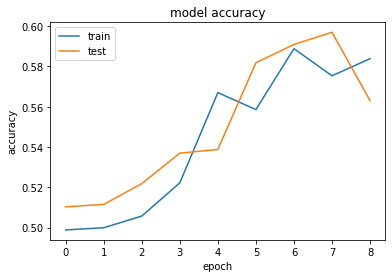

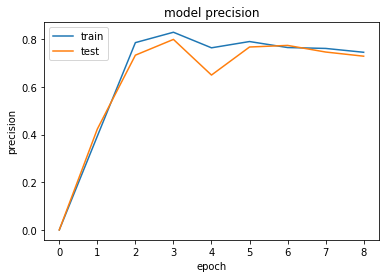

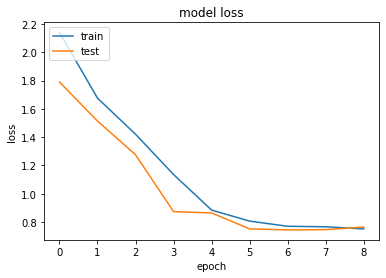

Epoch 1/100
233/233 [==============================] - 88s 380ms/step - loss: 0.6746 - accuracy: 0.6358 - precision: 0.6655 - recall: 0.4575 - f1_score: 0.5363 - val_loss: 0.6834 - val_accuracy: 0.7042 - val_precision: 0.6615 - val_recall: 0.8222 - val_f1_score: 0.7330
Epoch 2/100
233/233 [==============================] - 88s 377ms/step - loss: 0.6112 - accuracy: 0.6793 - precision: 0.6964 - recall: 0.6209 - f1_score: 0.6564 - val_loss: 0.6353 - val_accuracy: 0.7261 - val_precision: 0.7049 - val_recall: 0.7851 - val_f1_score: 0.7427
Epoch 3/100
233/233 [==============================] - 88s 377ms/step - loss: 0.5669 - accuracy: 0.7223 - precision: 0.7304 - recall: 0.6849 - f1_score: 0.7068 - val_loss: 0.5610 - val_accuracy: 0.7509 - val_precision: 0.7502 - val_recall: 0.7777 - val_f1_score: 0.7635
Epoch 4/100
233/233 [==============================] - 88s 378ms/step - loss: 0.5434 - accuracy: 0.7405 - precision: 0.7614 - recall: 0.7072 - f1_score: 0.7333 - val_loss: 0.5358 - val_accur

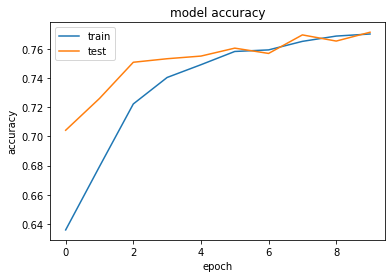

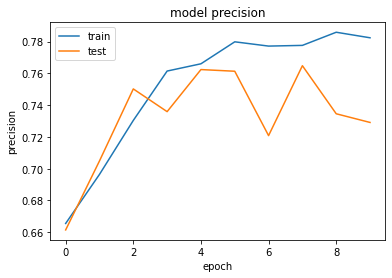

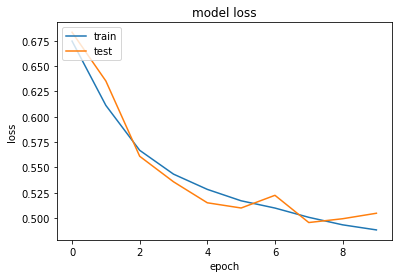

Epoch 1/100
233/233 [==============================] - 126s 541ms/step - loss: 0.6784 - accuracy: 0.6336 - precision: 0.5715 - recall: 0.7513 - f1_score: 0.6451 - val_loss: 0.6776 - val_accuracy: 0.6812 - val_precision: 0.6313 - val_recall: 0.8668 - val_f1_score: 0.7305
Epoch 2/100
233/233 [==============================] - 129s 555ms/step - loss: 0.6016 - accuracy: 0.6904 - precision: 0.6604 - recall: 0.7439 - f1_score: 0.6991 - val_loss: 0.6034 - val_accuracy: 0.7291 - val_precision: 0.7651 - val_recall: 0.6892 - val_f1_score: 0.7247
Epoch 3/100
233/233 [==============================] - 125s 538ms/step - loss: 0.5418 - accuracy: 0.7480 - precision: 0.7423 - recall: 0.7339 - f1_score: 0.7378 - val_loss: 0.5272 - val_accuracy: 0.7661 - val_precision: 0.7563 - val_recall: 0.7968 - val_f1_score: 0.7758
Epoch 4/100
233/233 [==============================] - 125s 538ms/step - loss: 0.5170 - accuracy: 0.7670 - precision: 0.7799 - recall: 0.7314 - f1_score: 0.7548 - val_loss: 0.5042 - val_a

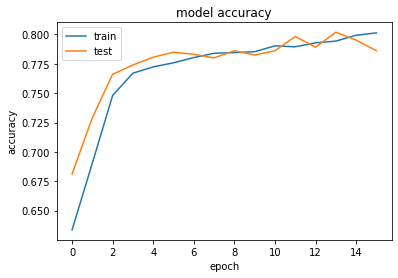

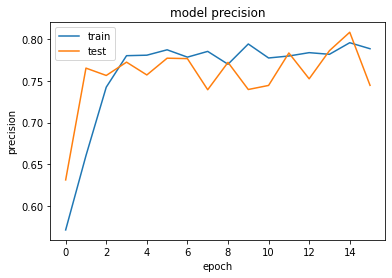

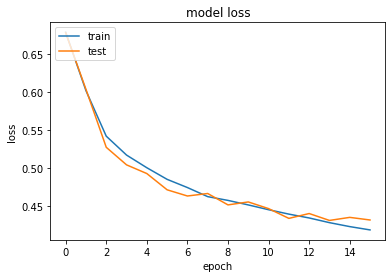

In [ ]:
if __name__ == '__main__':  

  # BiLSTM
  bilstm = createLSTM()
  train(bilstm, train_data)
  # test_model(bilstm, test_data)

  #CNN light
  cnn = createCNN()
  train(cnn, train_data)
  # test_model(cnn, test_data)

  #CNN ALexandre no weights
  model = create_model()
  train(model, train_data)
  # test_model(model, test_data)
